In [1]:
# Note: This code is adopted from the internet to get an idea about the datatset and time series modelling
# This code was not used in the final model building.
# THis is just for analysis
# Source: https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/
# Source: https://machinelearningmastery.com/how-to-develop-machine-learning-models-for-multivariate-multi-step-air-pollution-time-series-forecasting/


import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

In [2]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.grid'] = False
df=pd.read_csv('final_dataset_csv.csv', sep=',',header=0)
df = df.ffill()
test_data_size = (int(df.shape[0] * 0.20))
df_test = df.tail(test_data_size)
df.drop(df.tail(test_data_size).index, inplace = True) # remove and set aside 20% of dataset for testing.
TRAIN_SPLIT = int(df.shape[0]*0.80) # 85% training 15 % validation
print ("Training data frame = {}".format(df.head()))
print ("Testing data frame = {}".format(df_test.head()))
# they definitely needs optimization.
BATCH_SIZE = 32 # bacth size in batch-SGD/variants
BUFFER_SIZE = 64 # for shuffling the dataset
STEP = 1 # for creation of dataset

# Train and evaluate
STEPS_PER_EPOCH = 50 # hyperparameter
EPOCHS = 20 # hyperparameter

Training data frame =   FLOW_DATE  PRESENT_STORAGE_TMC  INFLOW_CUSECS  OUTFLOW_CUECS  tempC  \
0    1/1/11                46.42         2029.0           2000     28   
1    1/2/11                46.54         3084.0           1490     28   
2    1/3/11                46.64         2776.0           1491     26   
3    1/4/11                46.69         2311.0           1491     26   
4    1/5/11                46.70         1847.0           1491     26   

   windspeedKmph  precipMM  humidity  pressure (mB)  cloudcover (%)  \
0              6       0.3        74           1010              45   
1              7       0.3        72           1010              27   
2             11       0.4        76           1011              46   
3             12       0.4        80           1012              61   
4             10       3.2        81           1011              73   

   HeatIndexC  DewPointC  WindChillC  WindGustKmph  RES_LEVEL_FT  
0          23         17          22         

In [3]:
# x = df.drop('RES_LEVEL_FT', axis=1)
# y = df['RES_LEVEL_FT']
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle = False)
# x.columns

<AxesSubplot:xlabel='FLOW_DATE'>

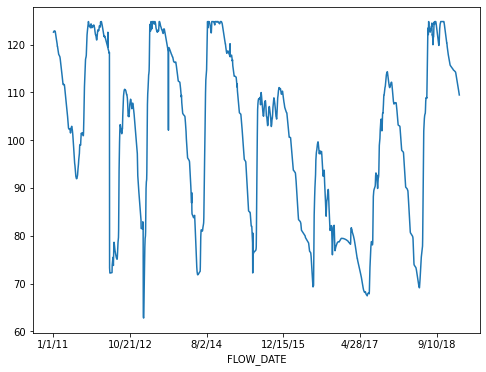

In [4]:
# univariate data
uni_data_df = df['RES_LEVEL_FT']
uni_data_df.index = df['FLOW_DATE']
uni_data_df.head()
uni_data_df.plot()

In [5]:
df.head()
df.columns
df[['OUTFLOW_CUECS']]
features = df[['PRESENT_STORAGE_TMC', 'INFLOW_CUSECS', 'OUTFLOW_CUECS', 'tempC', 'windspeedKmph', 'precipMM', 'humidity', 'pressure (mB)', 'cloudcover (%)', 'HeatIndexC', 'DewPointC', 'WindChillC', 'WindGustKmph', 'RES_LEVEL_FT']]
features.index = df['FLOW_DATE']
features.head()

,PRESENT_STORAGE_TMC,INFLOW_CUSECS,OUTFLOW_CUECS,tempC,windspeedKmph,precipMM,humidity,pressure (mB),cloudcover (%),HeatIndexC,DewPointC,WindChillC,WindGustKmph,RES_LEVEL_FT
FLOW_DATE,,,,,,,,,,,,,,
1/1/11,46.42,2029.0,2000,28,6,0.3,74,1010,45,23,17,22,10,122.59
1/2/11,46.54,3084.0,1490,28,7,0.3,72,1010,27,23,16,22,12,122.68
1/3/11,46.64,2776.0,1491,26,11,0.4,76,1011,46,22,16,21,16,122.75
1/4/11,46.69,2311.0,1491,26,12,0.4,80,1012,61,21,17,21,16,122.79
1/5/11,46.70,1847.0,1491,26,10,3.2,81,1011,73,22,17,21,14,122.80


array([<AxesSubplot:xlabel='FLOW_DATE'>, <AxesSubplot:xlabel='FLOW_DATE'>,
       <AxesSubplot:xlabel='FLOW_DATE'>, <AxesSubplot:xlabel='FLOW_DATE'>,
       <AxesSubplot:xlabel='FLOW_DATE'>, <AxesSubplot:xlabel='FLOW_DATE'>,
       <AxesSubplot:xlabel='FLOW_DATE'>, <AxesSubplot:xlabel='FLOW_DATE'>,
       <AxesSubplot:xlabel='FLOW_DATE'>, <AxesSubplot:xlabel='FLOW_DATE'>,
       <AxesSubplot:xlabel='FLOW_DATE'>, <AxesSubplot:xlabel='FLOW_DATE'>,
       <AxesSubplot:xlabel='FLOW_DATE'>, <AxesSubplot:xlabel='FLOW_DATE'>],
      dtype=object)

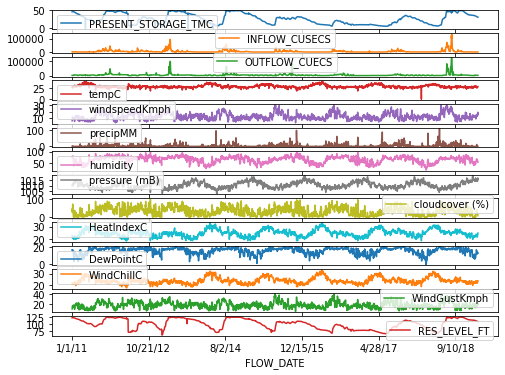

In [6]:
features.plot(subplots = True)

In [7]:
# standardize the data
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis = 0)
data_std = dataset[:TRAIN_SPLIT].std(axis = 0)
# data_mean
data_std.shape
dataset = (dataset-data_mean)/data_std
dataset.shape


(2649, 14)

In [8]:
data_mean

array([2.59014016e+01, 4.46808070e+03, 4.44802596e+03, 2.97404436e+01,
       1.27824445e+01, 3.56908919e+00, 6.52501180e+01, 1.01050307e+03,
       3.33808400e+01, 2.49702690e+01, 1.59896177e+01, 2.41434639e+01,
       1.80519113e+01, 1.00005460e+02])

In [9]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step) # step used here.
    data.append(dataset[indices])

    if single_step: # single_step used here.
      labels.append(target[i+target_size]) 
    else:
      labels.append(target[i:i+target_size]) 

  return np.array(data), np.array(labels)

In [10]:
dataset.shape

(2649, 14)

In [11]:
future_target = 90 # 90 future values
past_history = 600
print (dataset[:,13]) # water res levels needs to be predicted
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 13], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 13],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)
print(x_val_multi.shape)
print(y_val_multi.shape)


[1.28441861 1.28953705 1.29351806 ... 0.55930588 0.54679413 0.53712596]
(1519, 600, 14)
(1519, 90)
(0,)
(0,)


In [12]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

2021-07-18 11:06:04.482663: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-07-18 11:06:04.511278: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7feb2a933f40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-07-18 11:06:04.511299: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [13]:
np.isnan(y_train_multi).any()

False

In [14]:
#utility function
def create_time_steps(length):
  return list(range(-length, 0))

print(create_time_steps(20))

[-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


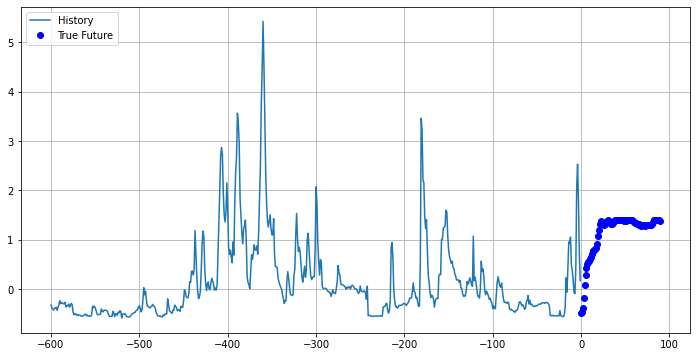

2021-07-18 11:06:04.906439: W tensorflow/core/kernels/data/cache_dataset_ops.cc:794] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [15]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [16]:
print (x_train_multi.shape[-2:])
print (x_train_multi.shape)
# make the LSTM model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(16,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(8, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(90)) # for 90 outputs

# multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
# multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=1.0), loss='mae')
multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')


multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

(600, 14)
(1519, 600, 14)
Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: nan

ValueError: in user code:

    /opt/anaconda3/envs/swarm/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:941 test_function  *
        outputs = self.distribute_strategy.run(
    /opt/anaconda3/envs/swarm/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/envs/swarm/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/envs/swarm/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/envs/swarm/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:909 test_step  **
        y_pred = self(x, training=False)
    /opt/anaconda3/envs/swarm/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /opt/anaconda3/envs/swarm/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 1]


In [ ]:


# Plot train and validation loss over epochs

def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.grid()

  plt.show()

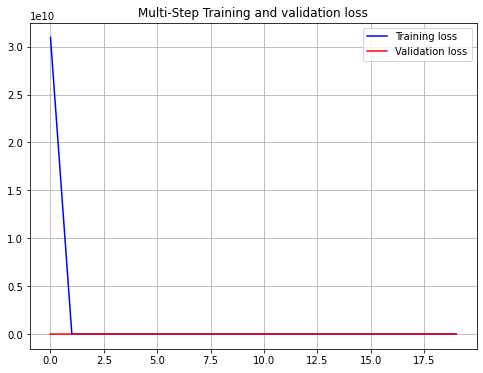

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [ ]:
print (multi_step_history)

{'loss': [30966505472.0, 0.8864197731018066, 0.8001033663749695, 0.9224298596382141, 0.8773328065872192, 0.8767867088317871, 0.7875632047653198, 0.9149683117866516, 0.8635150194168091, 0.8657340407371521, 0.7784743905067444, 0.9062165021896362, 0.8514755368232727, 0.85403972864151, 0.7722297310829163, 0.8951908349990845, 0.8393142223358154, 0.8431546688079834, 0.7634438872337341, 0.8874816298484802], 'val_loss': [1.0511037111282349, 1.0415027141571045, 1.032243013381958, 1.0343215465545654, 1.030418872833252, 1.0216327905654907, 1.0123419761657715, 1.0149577856063843, 1.0115323066711426, 1.003211498260498, 0.9946905970573425, 0.9979829788208008, 0.994953453540802, 0.9866137504577637, 0.9784833788871765, 0.9824345111846924, 0.979951798915863, 0.9722890257835388, 0.9645189642906189, 0.9687163233757019]}


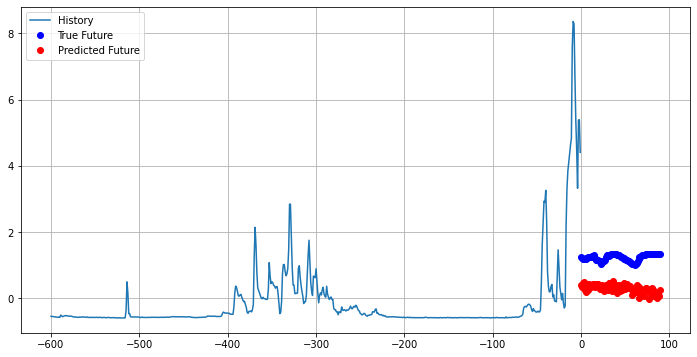

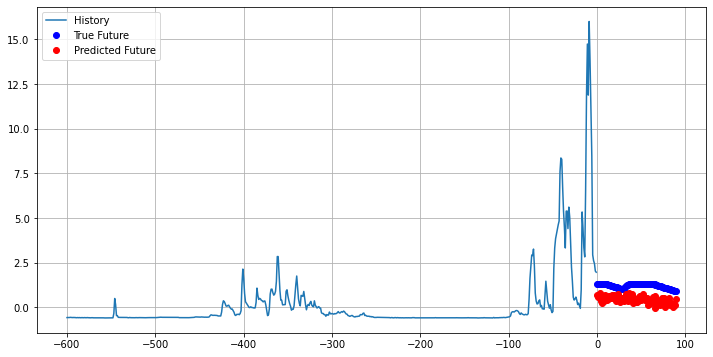

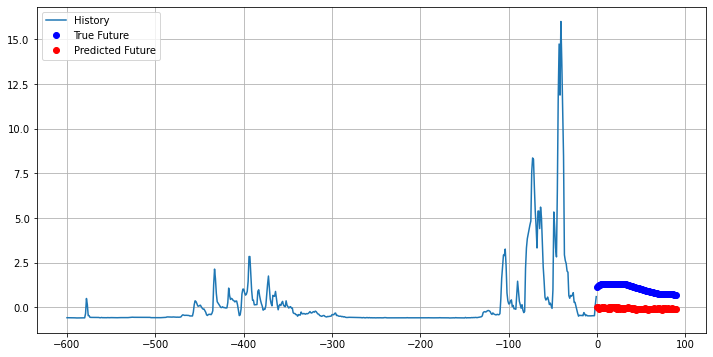

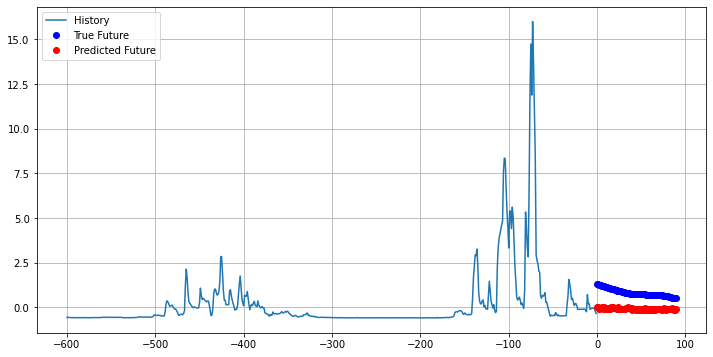

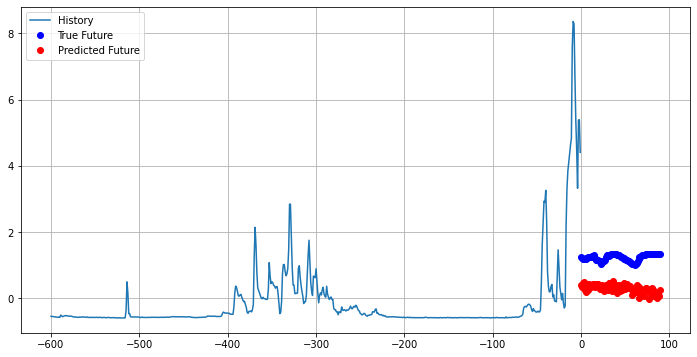

In [ ]:
for x, y in val_data_multi.take(5):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [ ]:
# perform test evaluation
test_features = df[['PRESENT_STORAGE_TMC', 'INFLOW_CUSECS', 'OUTFLOW_CUECS', 'tempC', 'windspeedKmph', 'precipMM', 'humidity', 'pressure (mB)', 'cloudcover (%)', 'HeatIndexC', 'DewPointC', 'WindChillC', 'WindGustKmph', 'RES_LEVEL_FT']]
test_features.index = df['FLOW_DATE']
# standardize the data
# test_features = df_test[]
dataset_test = features.values
data_mean = dataset_test.mean(axis = 0)
data_std = dataset_test.std(axis = 0)
# data_mean
data_std.shape
dataset_test = (dataset_test-data_mean)/data_std
dataset_test.shape
SPLIT = int(df_test.shape[0])

x_test_multi, y_test_multi = multivariate_data(dataset_test, dataset_test[:, 13],
                                             SPLIT, None, past_history,
                                             future_target, STEP)


test_data_multi = tf.data.Dataset.from_tensor_slices((x_test_multi, y_test_multi))
test_data_multi = test_data_multi.batch(BATCH_SIZE).repeat()

for x, y in test_data_multi.take(5):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])